# 1.1 PSSM generation

Generate PSSM files to extract evolutionary features using Mmseqs's easy_generate_pssm function.

The arguments are: we have the names of the arguments and inside () the format it accepts
* input_file (FASTA): path to the fasta file 
* database_input (FASTA): path to the uniref50 database or any database you want to perform the search 
* generate_searchdb (bool): Set it to True only the first time you run it to create the search database from the database input which is necessary for Mmseqs to run correctly
* database_output (str, optional): Optionally, you canname the database created from the database_input
* pssm_filename (str): name of the pssm file which stores the PSSM for all the sequences in the input
* output_dir (str): pssm_file will be split into individual PSSM files in this directory

So the generated output is basically:
the individual pssm_files stored in *output_dir* used by PossumFeatures(pssm_dir=output_dir)

In [1]:
from BioML.utilities.utils import MmseqsClustering

In [2]:
fasta_file = "../data/whole_sequence.fasta"

In [3]:
pssm_file = MmseqsClustering.easy_generate_pssm(input_file=fasta_file, database_input="../data/db_seq.fasta",
                                                generate_searchdb=True, pssm_filename="esterase.pssm", output_dir="pssm") # actualizar

start running createdb
It took 0.07075858116149902 second to run
start running search
It took 0.008486747741699219 second to run
start running generate_profile
It took 0.13269639015197754 second to run
start running convert profile to pssm
It took 0.08297467231750488 second to run


# 1.2 Extract Features

There are several features to extract:
   1. Physicochemical features from iFeatures https://github.com/Superzchen/iFeature
   2. Evolutionary features using PSSM and Possum https://possum.erc.monash.edu/
   3. Features or embeddings from Large language models 

In [3]:
from BioML.features.extraction import PossumFeatures, IfeatureFeatures, ExtractFeatures 
from BioML.utilities.utils import clean_fasta

Before substrate extraction you might want to clean the fast file of non canonical residues like X, U, B etc and to remove those shorter than 100 aamino acids for example.
The arguments are:
* possum_program (str): path to the POSSUM_Toolkit with the scripts to clean the fasta file
* fasta_file (FASTA): path to the fasta file
* out_fasta (FASTA): path to the cleaned fasta file
* min_aa (int): minimum length of the sequence

The generated output is:
* out_fasta which is used by all the other feature extraction programs.
Clean fasta should actually be used even before pssm_generation from Mmseqs

In [ ]:
clean_fasta("../POSSUM_Toolkit", fasta_file, "cleaned.fasta", 100)
fasta_file = "cleaned.fasta"

This class extract iFeature features and the most important arguments for the class are:
* program (str): path to the iFeature program
* output (str): path to the output directory

The output of the function ifeatures.extract(fasta_file)
*  A bunch of csv files stored in the output directory.

Each of the csv files represent one feature from the iFeature program repertoire


In [5]:
ifeatures = IfeatureFeatures("../iFeature")
ifeatures.extract(fasta_file)

iFeature features to be extracted: {'long': ['Moran', 'Geary', 'NMBroto'], 'short': ['QSOrder', 'GDPC', 'CTDT', 'PAAC', 'GAAC', 'SOCNumber', 'KSCTriad', 'APAAC', 'CTDD', 'CTDC', 'CKSAAGP', 'CTriad', 'GTPC']}
start running Ifeature programs
It took 15.259301900863647 second to run


This class extract possum features and the most important arguments for the class are:
* pssm_dir (str): path to the individual pssm files generated by Mmseqs
* output (str): path to the output directory
* program (str): path to the POSSUM_Toolkit

The output:
with this function you generate a bunch of tsv files stored in the output directory.

In [6]:
possum = PossumFeatures(pssm_dir="pssm", output="possum_features", program="../POSSUM_Toolkit")
possum.extract(fasta_file)

Possum features to be extracted: {'long': ['pssm_cc', 'tri_gram_pssm'], 'short': ['dpc_pssm', 'pse_pssm:1', 'smoothed_pssm:9', 'k_separated_bigrams_pssm', 'smoothed_pssm:5', 'smoothed_pssm:7', 'aac_pssm', 'dp_pssm', 's_fpssm', 'ab_pssm', 'pse_pssm:3', 'pse_pssm:2', 'tpc', 'rpm_pssm', 'pssm_composition', 'eedp', 'rpssm', 'pssm_ac', 'd_fpssm', 'edp']}
start running Possum programs
It took 187.8209524154663 second to run


For large fasta files of hundreds thousands of sequences I recommend using ExtractFeatures.
ExtractFeatures takes a large fasta file and splits it into smaller fasta files called groups_*.fasta with separate_bunch(base="group"). You could change the base to change the name of the files.

The arguments for the run_extraction_parallel function are:
* file (list[FASTA]): a list of fasta files
* num_threads (int): number of threads to use
* f (function): an arbitrary number of function to be applied to each fasta file. The function can be anyone that accepts a fasta file as an argument.

The output is a list of csv files stored in the different output directories from each fasta file


In [ ]:
extract = ExtractFeatures(fasta_file)
extract.separate_bunch()
file = list(extract.fasta_file.parent.glob("group_*.fasta"))

possum = PossumFeatures(pssm_dir="pssm", output="possum_features", program="../POSSUM_Toolkit")
ifeature = IfeatureFeatures("../iFeature")

extract.run_extraction_parallel(file, 100, possum.extract, ifeature.extract)

Possum features to be extracted: {'long': ['pssm_cc', 'tri_gram_pssm'], 'short': ['ab_pssm', 'edp', 'eedp', 'rpm_pssm', 'smoothed_pssm:5', 'pssm_composition', 'rpssm', 'pssm_ac', 'pse_pssm:1', 'pse_pssm:3', 's_fpssm', 'd_fpssm', 'tpc', 'smoothed_pssm:7', 'pse_pssm:2', 'dpc_pssm', 'k_separated_bigrams_pssm', 'dp_pssm', 'smoothed_pssm:9', 'aac_pssm']}
iFeature features to be extracted: {'long': ['Moran', 'NMBroto', 'Geary'], 'short': ['CTDD', 'GTPC', 'PAAC', 'GAAC', 'APAAC', 'CTDC', 'CTDT', 'GDPC', 'QSOrder', 'KSCTriad', 'CTriad', 'SOCNumber', 'CKSAAGP']}
start running Possum programs
It took 0.9275431632995605 second to run
start running Ifeature programs
It took 16.410173177719116 second to run


# 1.3  LLM embeddings

If you want you can easily generate large language model embeddings from models supported by Hugging Face's API

In [7]:
from BioML.deep import embeddings
from BioML.deep. train_config import LLMConfig

In [8]:
config = LLMConfig()
tokenizer = embeddings.TokenizeFasta(config)
embed = embeddings.ExtractEmbeddings(config)
tok = tokenizer.tokenize(fasta_file)

Generate embeddings from a FASTA file:
* fasta_file (FASTA): path to the fasta file
* model_name (str): name of the model
* option (str): The embeddings has the dimensions L*H where L is the number of aminoacids and H is the dimension of the features. The option can be "mean", "sum", "max" or "flatten" so it turns L * H into H. 
* save_path (str): path to the output file
* mode (str): write or return

The saved output 
* embeddings.csv

In [6]:
embeddings.generate_embeddings(fasta_file, model_name="facebook/esm2_t6_8M_UR50D", option="mean", 
                               save_path="embeddings.csv", mode="write")

# 2 Feature selection

If we combine features from multiple places the dimensions would be too high to handle, so normally ti would be wise to use some feature selection techniques:  
BioML implements at the moment 8 algorithms for classification and 6 for regression 
 
    1. Supervised: using Tree methods Random Forest and Xgboost, Recursive feature elmination
    2. Filter methods: Pearson correlation, Chi squared,
    3. Unsupervised methods like: PCA, ICA (independent component analysis)

In [4]:
import pandas as pd
from BioML.features import selection
from BioML.features.extraction import read_features

read features is a convenient function to read all the csv or tsv files generated by the feature extraction programs and returns a dataframe with all the features
The arguments are:
* program (str): the feature extraction program wether 'ifeature' or 'possum'
* ifeature_out (str): path to the output directory if ifeature features
* possum_out (str): path to the output directory if possum features
* file_splits (int): This arguments was added for ExtractFeatures that splits the large fasta files into smaller ones, it is the number of splits performed. In this case no splits so file_splits = 1 
* index (list): possum features don't save the sequence index with the tsvs unlike ifeature, which makes identifying each row back to the original sequence difficult (the order is kept) so you should provide the index if you are using possum features

The output is a dataframe with all the features concatenated

In [6]:
ifeat = read_features("ifeature", ifeature_out="ifeature_features", file_splits=1)
possum_feat = read_features("possum", possum_out="possum_features", file_splits=1, index=ifeat.index)
emb = pd.read_csv("embeddings.csv", index_col=0, header=None)

Warning possum_features/tri_gram_pssm_0.csv does not exist
Warning possum_features/k_separated_bigrams_pssm_0.csv does not exist


In [7]:
emb.columns.shape, ifeat.columns.shape, possum_feat.columns.shape

((320,), (2274,), (10330,))

The DataReader function takes in different formats and converts them into a single format (the conversion is necessary for the feature selection):

* label in different formats: string, ndarray, a list of pd.Series.
* It also takes features in different formats: a list or ndarray, dataframe, list of dataframes or a list of the different accepted formats and concatenates them

It will automatically remove features with 0 variance (meaning every value is the same), you can control the threshold

The output: 
* A class with the features

In [8]:
features = selection.DataReader("../data/esterase_labels.csv", [ifeat, possum_feat, emb], variance_thres=0)
#features.features.columns = features.features.columns.astype(str)
features

Data with:
    num. samples: 147
    num. columns: 12924
    variance threshold: 0
    sheet: None

### Custom splitting based on 30% sequence identity

It is recommended to split based on sequence identity so that the training, test or validation sets doesn't have sequence with more than 30% sequence identity.
You can use mmseqs to generate such clusters

In [1]:
from BioML.utilities.utils import MmseqsClustering
from BioML.utilities.split_methods import ClusterSpliter
from BioML.models.base import DataParser
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

### Generate different clusters of sequences based on an identity threshold of 30%.
It creates a cluster.tsv file. This tsv file has the first column the clusters names (which should be the same one as the features indices) and in the second column the idex of the sequence that resides within that cluster.  

For example: This means EH2(71) is a cluster with 3 sequences that share more than 30% sequence identity.

* EH2(71)	EH2(71)
* EH2(71)	EH4(67)
* EH2(71)	EH14(48)

This technique is actually very flexible, you can generate manually a cluster file if you want to customize the way you want to split your data into training and testing splits

easy_cluster function takes the following arguments:

* input_file (str or Path): path to the input sequence file
* cluster_at_sequence_identity (float): the sequence identity threshold
* cluster_tsv (str or Path): path to the output cluster file

The output:
* cluster.tsv

In [9]:
cluster = MmseqsClustering.easy_cluster(fasta_file, cluster_at_sequence_identity=0.3, 
                                        cluster_tsv="cluster.tsv")

start running cluster
It took 6.722121715545654 second to run
start running create tsv
It took 0.02847123146057129 second to run


Now split based on this sequence identity cluster, the clusters names can be strings or numbers as long as it is the same as the index of feautures dataframe.  
But if they are different, cluster names are different to the index of the dataframe, there is an additional groups argument in the split and train_test_split function that accepts a list with the names present in the cluster file and ordered as the rows in the dataframe

The clustersplitter splits the dataframes into training and testing sets based on the cluster file.
The arguments are:

* _cluster_info (str or Path): path to the cluster file
* num_splits (int): number of splits
* random_state (int): random seed
* stratified (bool): whether to use stratified sampling or not, only for classification

The function train_test_split is similar to the sklearn train_test_split function.
* X (Any iterable): features dataframe
* y (any iterable): labels array -> y is optional, if you don't provide it it returns X_train and X_test only
* test_size (float): proportion of the dataset to include in the test split (it doesn't always work since it has to follow the clusters)

The output is X_train, X_test, y_train, y_test

In [9]:
split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
X_train, X_test, y_train, y_test = split.train_test_split(features.features, features.label)

In [11]:
X_train.shape, len(X_train.values)

((117, 12924), 117)

The get_range_features arguments:
* features (pd.DataFrame): features dataframe
* num_features_min (int): minimum number of features
* num_features_max (int): maximum number of features
* step_range (int): step range between num_features_min and num_features_max

The output:
* feature_range (list): list of feature dimensions to extract for each of the feature selection algorithm

You could skip this function and give an list of feature dimensions diectly to construct features

In [7]:
problem ="classification"
feature_range = selection.get_range_features(features.features, num_features_min = 20, num_features_max=60, step_range=10)
feature_range

[20, 30, 40, 50, 60]

Featureselection class arguments are:

* excel_file (str or Path): path to the excel file to save the features
* filter_args : a class with filter_args attributes, which is a dict containing the selection algorithms
* num_thread (int): number of threads
* seed (int): random seed
* scaler (str): scaler to use to scale the features before runing the selection

The construct_features function is the function that actually runs the selection algorithms.
* X (Any iterable): features dataframe
* X_train (Any iterable): training features dataframe
* X_test (Any iterable): testing features dataframe
* y_train (Any iterable): training labels array
* feature_range (list): list of feature dimensions to extract for each of the feature selection algorithm

The output is:
* excel_file (saved): with the features, each sheet is a selection algorithm and feature_dimension
* feature importance plot (saved): with the shap package https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* A csv of the feature importance (saved)


In [9]:
# select features
if problem == "classification":
    filters = selection.FeatureClassification()
elif problem == "regression":
    filters = selection.FeatureRegression()

select = selection.FeatureSelection("classification_results/filtered_features.xlsx", filters, num_thread=2, seed=10, 
                                    scaler="robust")

select.construct_features(features.features, X_train, X_test, y_train, feature_range)

14-04-2025 14:29:31 INFO Reading the features
14-04-2025 14:29:31 INFO Starting feature selection and using the following parameters
14-04-2025 14:29:31 INFO seed: 10
14-04-2025 14:29:31 INFO filtering the features


classification filter: mutual_info
classification filter: Fscore
classification filter: chi2
classification filter: FechnerCorr
classification filter: KendallCorr
generating a feature set of 20 dimensions
generating a feature set of 30 dimensions
generating a feature set of 40 dimensions
generating a feature set of 50 dimensions
generating a feature set of 60 dimensions


<Figure size 800x950 with 0 Axes>

# 4. Outlier detection

You can also eliminate outliers in your dataset which could decrease model performance.
Although, generally, if you have a lot of data outliers won't matter much.  
It is unsupervised so it only needs the features. It accepts the following formats

1. excel files
2. Pandas dataframe
3. Series, ndarray
4. csv file

It leverages 8 different outlier detection algorithms and gives you a voting. 
If you give it an excel file where there are different sheets. It will iterate through all of them.

In [21]:
from BioML.utilities.outlier import OutlierDetection

THe OutlierDetection class arguments are:

* feature_file (str or Path): path to the excel file
* output (str or Path): path to the output file
* num_thread (int): number of threads

The run function outputs a dataframe with the outliers in it.
* "classification_results/outliers.csv" (saved)

In [22]:
detection = OutlierDetection("classification_results/filtered_features.xlsx", output="classification_results/outliers.csv", num_thread=4)
outliers = detection.run()

In [23]:
outliers.head(20)

,0
EH144(1),281
EH115(8),226
EH121(5),198
EH74(17),169
EH125(4),142
EH98(11),116
EH85(13),116
EH48(23),102
EH61(20),86
EH46(23),85


## Iterate through multiple feature sheets

You have many features sets that were selected and saved in the excel file from the previous feature selection step. You want to test which feature set is better for your data relatively fast -> you could use iterate_excel from the utilities and the iterate_multiple_features method from Trainer.

The iterate_multiple_features method from Trainer accepts an iterator of (feature dataframe, label column name, name) generated by iterate_excel: 
    1. name is used to identify the features later in the results
    2. feature dataframe should contain a column with teh labels
    3. label column name within the feature dataframe

Then it calls the run_training method from the Trainer iteratively and gathers performance metrics for different sheets.
run_training only runs the models without tuning, stacking or esembling.
Finally it write the results for each sheet

Once you have picked the best performing sheet you could run again the previous steps and perform tuning, stacking and ensembling

Iterate excel reads all the sheets from an excel and yields (feature dataframe, label column name, sheet)

In [1]:
from BioML.utilities.utils import write_results, iterate_excel
from BioML.models.base import DataParser
from BioML.models.classification import Classifier
from BioML.models.regression import Regressor
from BioML.models.base import PycaretInterface, Trainer, DataParser
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np
from BioML.utilities.utils import write_results
from sklearn.linear_model import PassiveAggressiveClassifier
from BioML.utilities.split_methods import ClusterSpliter

By default pycaret logs the hyperparameters and metrics in MlFLow (similar to wandb or tensorboard) but since we are only testing the features
we don't need registry of all those runs.
So we can disable log_experiment

In [ ]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=4, 
                                  output_path="classification_results", optimize="MCC", log_experiment=False) 
classifier = Classifier(optimize="MCC", drop=(), selected=(), add=())
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=50)

04-04-2025 12:08:37 INFO ------------------------------------------------------------------------------
04-04-2025 12:08:37 INFO PycaretInterface parameters
04-04-2025 12:08:37 INFO Seed: 250
04-04-2025 12:08:37 INFO Budget time: 20
04-04-2025 12:08:37 INFO The number of models to select: 4
04-04-2025 12:08:37 INFO Output path: classification_results
04-04-2025 12:08:37 INFO ----------------Trainer inputs-------------------------
04-04-2025 12:08:37 INFO Number of kfolds: 5
04-04-2025 12:08:37 INFO Number of retuning iterations: 50
04-04-2025 12:08:37 INFO Test size: 0.2


The arguments for iterate_excel are:

* excel_file (str): the path to the excel file with all the selected features
* parser (DataParser): the parser for the excel file
* label (str): The labels for the features it can be any of the accepted formates by parser
* outliers (Iterable[str]): An iterable containing the indices to remove from the training set

The output is:
* yield -> (feature dataframe, label column name, sheet name)

The arguments for iterate_multiple_features are:

* generator (Generator): A generator that yields (feature dataframe, label column name, name)
* training_output (str): the path to the training output
* split_strategy (ClusterSpliter): The strategy for splitting the training dataset

The output is:
* "training_output / training_results.xlsx" (saved)
* "output_path/ config_setup_pycaret.csv" (saved) from PycaretInterface

In [4]:
generator = iterate_excel("classification_results/filtered_features.xlsx", parser=DataParser, 
                          label="../data/esterase_labels.csv", outliers=())

split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
training.iterate_multiple_features(generator, training_output="classification_results", split_strategy=split)

2025/04/04 12:08:42 INFO mlflow.tracking.fluent: Experiment with name 'Classification' does not exist. Creating a new experiment.
04-04-2025 12:08:42 INFO Added metrics for classification: Average precision
04-04-2025 12:08:42 INFO --------------------------------------------------------
04-04-2025 12:08:42 INFO Training classification models
04-04-2025 12:08:42 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy']
04-04-2025 12:08:42 INFO The number of models used 19
04-04-2025 12:08:42 INFO Time budget is 20 minutes
2025/04/04 12:08:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
04-04-2025 12:08:46 INFO Model lr trained in 0.055 minutes
2025/04/04 12:08:48 WARNING mlflow.models.model: Model logged without a signature and input example. Ple

KeyboardInterrupt: 

# 5. Model Training: Classification

Now that you know which feature set is the best -> you train, tune and ensemble models using only that specific sheet

In [20]:
from BioML.models.classification import Classifier
from BioML.models.regression import Regressor
from BioML.models.base import PycaretInterface, Trainer, DataParser
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np
from BioML.utilities.utils import write_results
from sklearn.linear_model import PassiveAggressiveClassifier
from BioML.utilities.split_methods import ClusterSpliter

In [23]:
pd.read_excel("/home/ruite/Projects/BioML/examples/classification_results/not_tuned/training_results.xlsx", sheet_name=["train", "test_results"], index_col=[0,1,2])["test_results"].head(20)

,,,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
,Accuracy,AUC,,,,,,
lr_Logistic Regression,0.8333,0.8054,0.6923,0.9000,0.7826,0.6512,0.6659,0.7355
Voting Classifier,0.8333,0.8167,0.6923,0.9000,0.7826,0.6512,0.6659,0.7564
PassiveAggressiveClassifier_PassiveAggressiveClassifier,0.6667,0.6335,0.3846,0.7143,0.5000,0.2823,0.3128,0.5414
Stacking Classifier,0.6000,0.7964,0.1538,0.6667,0.2500,0.1045,0.1570,0.7232
nb_Naive Bayes,0.5333,0.6109,0.0000,0.0000,0.0000,-0.0660,-0.1624,0.4872


### We first read the data and create train and test set based on the sequence identity threshold
The DataParser returns a dataframe with the labels as a column in the same dataframe, which is why we don't need the y_train and the y_test.
This is how Pycaret likes it (the library used by BioML to train machine learning models) 

Here I'm only using one of the sheets for this example, but we don't know which of the sheets would perform better so we might need to iterate through the sheets, train the models and collect the performance for each sheet.

In [4]:
data = DataParser("classification_results/filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_60")
data = DataParser("../data/esterase_features.xlsx", "../data/esterase_labels.csv", sheets="ch2_20")
split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
X_train, X_test, _, _ = split.train_test_split(data.features, data.features[data.label])

In [5]:
X_train.head()

,hydrophobicity_FASG890101.2.residue25,alphaticr.negativecharger.gap5,BHAR880101.lag9_moran,tri_gram_pssm7077,tri_gram_pssm286,tri_gram_pssm466,tri_gram_pssm3493,tri_gram_pssm1298,tri_gram_pssm5728,tri_gram_pssm7468,tri_gram_pssm1297,tri_gram_pssm4023,tri_gram_pssm3159,tri_gram_pssm7678,tri_gram_pssm7234,tri_gram_pssm5801,tri_gram_pssm5367,tri_gram_pssm7177,target
EH111(8),19.762846,0.040486,0.084414,0.002188,0.051697,0.048276,0.016844,0.004625,0.018720,0.010066,0.001115,0.088146,0.019392,0.030169,0.035476,0.080685,0.070774,0.001775,0
EH15(42),26.279863,0.052265,-0.051729,0.010338,0.573238,0.169123,0.121183,0.019340,0.333862,0.171416,0.006026,0.451274,0.081755,0.229442,0.082068,0.262047,0.289476,0.006036,1
EH117(6),25.267666,0.036876,-0.027442,0.007047,0.075657,0.082276,0.037046,0.010299,0.030363,0.023863,0.003769,0.188441,0.026338,0.058306,0.080121,0.122729,0.022790,0.009361,0
EH11(53),19.032258,0.032895,0.042455,0.065163,0.875810,0.447033,0.195845,0.096829,0.513410,0.182430,0.031378,0.635770,0.265902,0.460689,0.281517,0.613932,0.404746,0.028915,1
EH135(2),24.555160,0.047273,0.035283,0.004763,0.053927,0.031520,0.007024,0.005613,0.022906,0.011953,0.005436,0.069167,0.018054,0.040943,0.023389,0.035671,0.049431,0.004665,0


There are 3 classes important for training machine learning models in BioML. 

1. The pycaretInterface which provides a thin layer between pycaret and BioML.
2. Classifer or Regressor clases which has the training arguments
3. Then the Trainer class that takes both classes to perform classification or regression task.

This modularity is similar to other machine learning framewoeks like pytorch-lightning and Hugging Face

I recommend learning more about pycaret since it does many things: https://pycaret.readthedocs.io/en/latest/

Currently there are 19 supported models, but you can supply your custom models as well as long as it is compatible with the scikit learn API. A fit and a predict or predict_proba methods 

In [5]:
problem = "classification"
passive = PassiveAggressiveClassifier()

The PycaretInterface class takes the following arguments

* problem (str): classification or regression
* seed (int): random seed
* budget_time (int): time budget
* best_model (int): How many models to select for tuning and ensembling
* output_path (str): path to the output folder where the plots are saved
* optimize (str): optimization metric for tune model, ensembling and satcking -> it doesnt affect the training

The Trainer class takes the following arguments:

* caret_interface (PycaretInterface): an instance of the PycaretInterface class
* args (Classifier or Regressor): an instance of the Classifier or Regressor class
* num_splits (int): number of splits
* test_size (float): test size
* num_iter (int): number of iterations
* cross_validation (bool): cross validation

The Classifier and Regressor classes take the following arguments:

* drop (list): list of models to drop
* selected (list): list of models to select
* add (list): list of models to add
* plot (list): list of plots to plot
* optimize (str): optimization metric for sorting the model results, so the best models according to the optimize are at the top


In [8]:
if problem == "classification":
    args = Classifier(optimize="MCC", drop=(), selected=(), add=(passive), plot=("learning", "confusion_matrix", "class_report"))
elif problem == "regression":
    args = Regressor(optimize="RMSE", drop=(), selected=(), add=(), plot=("learning", "residuals", "error"))
    
experiment = PycaretInterface(problem, 250, budget_time=20, best_model=3, 
                                  output_path="classification_results", optimize="MCC", log_experiment=False)
training = Trainer(experiment, args, num_splits=5, test_size=0.2,  num_iter=50, cross_validation=True)

04-04-2025 09:02:58 INFO ------------------------------------------------------------------------------
04-04-2025 09:02:58 INFO PycaretInterface parameters
04-04-2025 09:02:58 INFO Seed: 250
04-04-2025 09:02:58 INFO Budget time: 20
04-04-2025 09:02:58 INFO The number of models to select: 3
04-04-2025 09:02:58 INFO Output path: classification_results
04-04-2025 09:02:58 INFO ----------------Trainer inputs-------------------------
04-04-2025 09:02:58 INFO Number of kfolds: 5
04-04-2025 09:02:58 INFO Number of retuning iterations: 50
04-04-2025 09:02:58 INFO Test size: 0.2


The arguments for generate_training_results are:

* X_train (pd.DataFrame): training data
* y_train (str): the name of the label column, since Pycaret needs the dataframe to have the labels and the features together in the X_train
* X_test (pd.DataFrame): test data, it is a keyword argument (so you need to specify test_data=X_test,)
* tune (bool): whether to tune the models
* fold_strategy (ClusterSpliter): an instance of the ClusterSpliter class which has the cluster information

The output: 
* results dict[str, dict[str, pd.DataFrame]] (returned): The dataframe has the different performance metric liek acc, precision, recall, etc
* The models dict[str, dict[str, Any]] (returned): All the train models, 19 classifiers or 23 regressors
* model_plots (saved): The plots of the best models saved in the output_path argument in PycaretInterface
* config_setup_pycaret.csv (saved): The config file with the settings used by PycaretInterface

In [9]:
results, models = training.generate_training_results(X_train, data.label, tune=True, test_data=X_test, fold_strategy=split)

04-04-2025 09:03:01 INFO Added metrics for classification: Average precision
04-04-2025 09:03:01 INFO --------------------------------------------------------
04-04-2025 09:03:01 INFO Training classification models
04-04-2025 09:03:01 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy', PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)]
04-04-2025 09:03:01 INFO The number of models used 20
04-04-2025 09:03:01 INFO Time budget is 20 minutes
04-04-2025 09:03:04 INFO Model lr trained in 0.047 minutes
04-04-2025 09:03:0

Pycaret also generates different plots for the models it trains, like learning curves, validation curves, Precision Recall Curve, AUC etc: 
You can add more plots by modifying the plots argument in the classifier or regressor class

You can see the full list of plots here: https://pycaret.readthedocs.io/en/stable/api/classification.html#pycaret.classification.plot_model

Let's explain the 3 plots that I included by default for the classification: ("learning", "confusion_matrix", "class_report")
For regression these are the 3 plots: ("residuals", "error", "learning")
Here is an example learning curve plot.

You can access directly the pycaret class and play with it like this

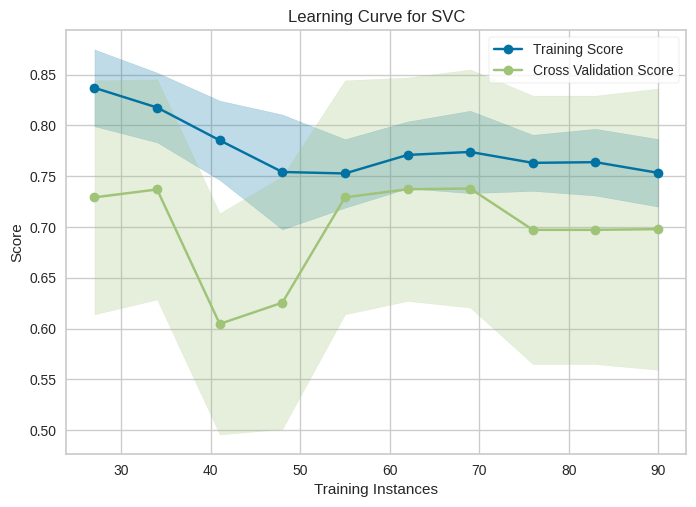

In [10]:
experiment.pycaret.plot_model(models["not_tuned"]["train"]["rbfsvm"], "learning")

Then if we want we can generate the predictions for the test or holdout set by providing with the trained models and finally 
we save both the training and the test set results

Looking at the results we can find out which models have performed well and see how we could combine them. Currently it combines automatically teh best 3 but that might not be the best approach.

The argument is :
* the models dict[str, dict[str, Any]]: The trained models

The output is:

* test_set_predictions (returned -> dict[str, pd.DataFrame]): The test set predictions

In [11]:
test_set_predictions = training.generate_holdout_prediction(models)

The write_results argumets:
* training_output (str): the path to the training output
* sheet_name (str): the name of the sheet
* sorted_results (pd.DataFrame): the sorted results
* top_params (pd.Series, optional): the hyperparameters of the best models

The output:
* "training_output / training_results.xlsx" (saved)
* "training_output / top_hyperparameters.xlsx" (saved)

In [12]:
training_output = "classification_results"
l = []
for tune_status, result_dict in results.items():
    for key, value in result_dict.items():
        write_results(f"{training_output}/{tune_status}", *value, sheet_name=key)
    write_results(f"{training_output}/{tune_status}", test_set_predictions[tune_status] , sheet_name=f"test_results")

## 5.2 Save Model from pre-trained

If you noticed, the previous step doesn't save any model only the training results. That is because both are separate blocks, and you need to use save_model to save them.

To save the models you can train the model with all the data or save the model trained only with the training data

In [45]:
models["tuned"]["train"]

{'qda': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.8258792813861613,
                               store_covariance=False, tol=0.0001),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                      metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                      weights='uniform'),
 'nb': GaussianNB(priors=None, var_smoothing=0.7918521648729947)}

In [13]:
from BioML.models import save_model

GenerateModel arguments are:
* trainer (Trainer): the trainer object, it should have been used in the previous step

The finalize_model arguments are:
* sorted_model (dict or Any): the model to finalize, it can be a dictrionary or a model object
* index (int, optional): if it is a dictionary you need to indicate the index of the model you want to finalize

The output of finalize_model is:
* The fitted model with all the data

The save_model arguments are:
* model (Any): the model to save
* filename (str): the filename to save the model

The output of save_model is:
* "classification_results/saved_models/{status}_{name}" -> the program adds .pkl automatically so no need for an extension

In [19]:
generate = save_model.GenerateModel(training)
for status, model in models.items():
    for key, value in model.items():
        if key == "train":
            for num, (name, mod) in enumerate(value.items()):
                if num > training.experiment.best_model - 1 : break
                final_model = generate.finalize_model(value, num)
                generate.save_model(final_model, f"classification_results/saved_models/{status}_{name}")
        else:
            final_model = generate.finalize_model(value)
            generate.save_model(final_model, f"classification_results/saved_models/{key}_{status}")

04-04-2025 09:10:12 INFO ----------Finalizing the model by training it with all the data including test set--------------
04-04-2025 09:10:13 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:13 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:14 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:15 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:15 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:16 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:16 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:17 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


04-04-2025 09:10:18 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


## 5.3 Save Model from scratch

This is an example on how to train on a few or a single model using the selected argument and save that 

In [20]:
from BioML.models import save_model

In [25]:
data = DataParser("classification_results/filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_60")
experiment = PycaretInterface("classification", 200, budget_time=20, best_model=3, 
                                  output_path="classification_results", optimize="MCC", experiment_name="generate_model", log_experiment=False)
classifier = Classifier(optimize="MCC", selected=("qda", "rbfsvm", "ridge"))
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=30)


04-04-2025 09:11:38 INFO ------------------------------------------------------------------------------
04-04-2025 09:11:38 INFO PycaretInterface parameters
04-04-2025 09:11:38 INFO Seed: 200
04-04-2025 09:11:38 INFO Budget time: 20
04-04-2025 09:11:38 INFO The number of models to select: 3
04-04-2025 09:11:38 INFO Output path: classification_results
04-04-2025 09:11:38 INFO ----------------Trainer inputs-------------------------
04-04-2025 09:11:38 INFO Number of kfolds: 5
04-04-2025 09:11:38 INFO Number of retuning iterations: 30
04-04-2025 09:11:38 INFO Test size: 0.2


In [26]:
sorted_results, sorted_models, top_params = training.run_training(data.features, data.label)

04-04-2025 09:11:40 INFO Added metrics for classification: Average precision
04-04-2025 09:11:40 INFO --------------------------------------------------------
04-04-2025 09:11:40 INFO Training classification models
04-04-2025 09:11:40 INFO The models used ('qda', 'rbfsvm', 'ridge')
04-04-2025 09:11:40 INFO The number of models used 3
04-04-2025 09:11:40 INFO Time budget is 20 minutes
04-04-2025 09:11:41 INFO Model qda trained in 0.015 minutes
04-04-2025 09:11:42 INFO Model rbfsvm trained in 0.011 minutes
04-04-2025 09:11:43 INFO Model ridge trained in 0.009 minutes
04-04-2025 09:11:43 INFO Training over: Total runtime 0.035 minutes


In [27]:
generate = save_model.GenerateModel(training)
models =  generate.train_by_strategy(sorted_models, "majority")
final_model = generate.finalize_model(models)
generate.save_model(final_model, "classification_results/single_model/logistic")

04-04-2025 09:12:05 INFO --------Creating an ensemble model--------
04-04-2025 09:12:05 INFO ----------Creating a majority voting model--------------
04-04-2025 09:12:05 INFO fold: 5
04-04-2025 09:12:05 INFO weights: None
04-04-2025 09:12:06 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


# 6. Prediction

Finally once you have the models you can make predictions on new data.

In [1]:
from BioML.models import predict
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [2]:
training_features = "classification_results/filtered_features.xlsx"
label = "../data/esterase_labels.csv"
outlier_train=()
outlier_test=()
sheet_name="chi2_60"
problem="classification"
model_path="classification_results/single_model/logistic"
scaler="robust"

#### Generate the predictions

The prediccions are appended to the features dataframe, if it is classification it returns
the probability of being in class 0 or class 1

The argument for the predict function are:

* test_features (pandas.DataFrame): The test features
* model_path (str): The path to the model, you don't need to scale the test features, becuase the saved model has then entire pipeline saved
* problem (str): The problem type, classification (it returns the probability of being in class 0 or class 1), regression it returns the value

The output of the predict function is:

* The predictions (pd.DataFrame): The predictions are appended to the features

In [3]:
feature = predict.DataParser(training_features, label, outliers=outlier_train, sheets=sheet_name)
test_features = feature.remove_outliers(feature.read_features(training_features, "chi2_60"), outlier_test)
predictions = predict.predict(test_features, model_path, problem)

In [4]:
predictions.head()

,CHAM810101.lag23_NMBroto,CHOC760101.lag22_Geary,CIDH920105.lag1_Moran,CHAM820102.lag4_Moran,Schneider.lag1_SOCNumber,pssm_cc360,pssm_cc542,pssm_cc662,pssm_cc744,pssm_cc1025,...,CHAM810101.lag7_NMBroto,CHAM810101.lag9_NMBroto,CHAM810101.lag24_NMBroto,CHAM810101.lag30_NMBroto,DAYM780201.lag26_NMBroto,CIDH920105.lag3_Geary,CIDH920105.lag11_Geary,CIDH920105.lag16_Geary,CIDH920105.lag23_Geary,prediction_label
EH1(72),-0.086296,1.037206,0.028302,-0.082859,0.371161,-0.000232,-0.000284,-0.000167,-0.000974,-0.001420,...,-0.168890,0.041882,0.029023,0.013333,0.002101,0.966769,1.092017,1.031714,1.037640,1
EH2(71),-0.110262,1.025836,-0.045634,-0.026907,0.348699,-0.000486,0.000237,-0.000954,-0.000170,-0.000966,...,0.053429,0.019795,-0.158698,-0.071886,0.005959,0.996057,0.985778,0.999326,1.039344,1
EH3(69),-0.125391,1.050111,0.024718,0.003147,0.346771,-0.000700,0.000922,-0.000458,-0.000875,-0.001095,...,0.076793,-0.041301,0.079643,-0.111475,0.029596,0.977896,0.919151,0.881323,1.109520,1
CalB(68),0.135638,1.005781,0.032854,-0.042622,0.251895,0.000807,-0.000265,0.001517,0.001502,-0.001548,...,0.018115,-0.024326,-0.017794,0.059463,0.012514,1.072358,0.999313,0.959426,1.012822,1
EH4(67),-0.201467,1.008612,-0.042323,-0.007536,0.340954,-0.000667,-0.000236,-0.000500,-0.000306,-0.000731,...,0.133993,0.030291,-0.143633,-0.117702,-0.054452,1.018159,1.068451,1.038840,1.027438,1


#### Optional if you want to filter predictions based if that test sample is within the applicability domain

Applicability domain compares eucleadian distance between the features from the training and features from the test.   
If the distance is far from a set threshold then that prediction is discarded since it deviates from the samples the model have seen during training  
Testing on the training dataset it discards a few as well so the error can be quite high

In [5]:
transformed, scaler_dict, test_x = predict.scale(scaler, feature.drop(), test_features)
filtered_pred = predict.domain_filter(predictions, transformed, test_x, 5) # it returns the predictions appended to the features

In [6]:
filtered_pred.shape, predictions.shape

((130, 63), (147, 61))

 if you don't apply the domain filter, you can just use the predictions but you have to add a new Index column to sample_0, sample_1, etc to filter the fasta files into positive or negative

In [7]:
predictions["Index"] = [f"sample_{x}" for x, _ in enumerate(predictions.index)]
col_name = ["prediction_score", "prediction_label", "AD_number", "Index"]
predictions = predictions.loc[:, predictions.columns.str.contains("|".join(col_name))] # only keep the columns with the prediction scores

### Separate the fasta file into positive or negative only make sense if it is a classification task

In [6]:
fasta_file = "../data/whole_sequence.fasta"
res_dir = "classification_results"

In [7]:
extractor = predict.FastaExtractor(fasta_file, res_dir)
positive, negative = extractor.separate_negative_positive(predictions)


NameError: name 'predict' is not defined

In [13]:
extractor.extract(positive, negative, positive_fasta="positive.fasta", negative_fasta=f"negative.fasta")

## Finetuning large language models

In [ ]:
from BioML.deep import finetuning as ft
from BioML.deep.train_config import LLMConfig, SplitConfig, TrainConfig
import pandas as pd
from BioML.utilities.utils import load_config

For regression tasks use num_classes = 1, and change the optimize to val_R2 for instance.
Go to BioML.deep.finetuning to see all the available metrics
You can change optimize_mode to 'min' if it has to decrease
To see the hyperparameters and configurations you can open mlflow  
The command should be run (terminal) in the directory where logs are, specified by train_config.save_dir
mlflow server --host 127.0.0.1 --port 8080 

! mlflow server --host 127.0.0.1 --port 8080 # to run terminal commands in jupyter you can use this and then go to 
http://127.0.0.1:8080 or http://localhost:5000

In [2]:
label = pd.read_csv("../data/esterase_labels.csv", index_col=0).to_numpy().flatten()
fasta_file = "../data/whole_sequence.fasta"

In [3]:
train_config = TrainConfig(num_classes=2, optimize="Val_MCC", optimize_mode="max", max_epochs=3, root_dir="LLM_results") # for regression do num_classses = 1 
llm_config = LLMConfig()
split_config = SplitConfig()

In [ ]:
lr=1e-3
use_best_model = True
tokenizer_args: dict = load_config("") # tokenizer_config.json
lightning_trainer_args = {}
# Placeholder for the training loop call
model, data_module, best_model_path, peft_output = ft.training_loop(fasta_file, label, lr, train_config, llm_config, 
                                                       split_config, tokenizer_args, 
                                                       lightning_trainer_args, use_best_model)

Seed set to 42
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


trainable params: 846,402 || all params: 8,687,165 || trainable%: 9.7431


Loading `train_dataloader` to estimate number of stepping batches.
/home/ruite/miniforge3/envs/bioml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/ruite/miniforge3/envs/bioml/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 8.7 M  | train
--------------------------------------------
846 K     Trainable params
7.8 M     Non-trainable params
8.7 M     Total params
34.749    Total estimated model params size (MB)
204       Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ruite/miniforge3/envs/bioml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric Val_MCC improved. New best score: 0.034
Epoch 0, global step 12: 'Val_MCC' reached 0.03414 (best 0.03414), saving model to '/home/ruite/Projects/BioML/examples/LLM_results/model_checkpoint/epoch=0-Val_MCC=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 24: 'Val_MCC' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 36: 'Val_MCC' was not in top 1
`Trainer.fit` stopped: `max_epochs=3` reached.
/home/ruite/miniforge3/envs/bioml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test_AUROC           0.8616070747375488
        Test_Acc            0.6000000238418579
 Test_Average_Precision     0.8665806651115417
    Test_Cohen_Kappa        0.15094339847564697
         Test_F1            0.6000000238418579
        Test_MCC            0.2857142984867096
     Test_Precision         0.6000000238418579
       Test_Recall          0.6000000238418579
          loss              0.6424059271812439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/ruite/Projects/BioML/examples/LLM_results/model_checkpoint/epoch=0-Val_MCC=0.03.ckpt
Loaded model weights from the checkpoint at /home/ruite/Projects/BioML/examples/LLM_results/model_checkpoint/epoch=0-Val_MCC=0.03.ckpt
/home/ruite/miniforge3/envs/bioml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test_AUROC                 0.78125
        Test_Acc            0.5333333611488342
 Test_Average_Precision     0.7894397974014282
    Test_Cohen_Kappa                0.0
         Test_F1            0.5333333611488342
        Test_MCC           0.024397501721978188
     Test_Precision         0.5333333611488342
       Test_Recall          0.5333333611488342
          loss              0.6824653744697571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


There will be 2 model folders after training, they contain the exact same model but they are loaded differently: 
train_config.root_dir / train_config.adapter_output: Where PEFT adapters are saved so you can use the HuggingFace APi from load_adapter

from BioML.uilities.deep_utils import load_adapter

Use the load_adapter function to get the trained model

model = load_adapter(best_model_path, llm_config)

Then there is train_config.root_dir / train_config.model_checkpoint_dir -> saved by the pytorch lightning
If you want to use the lighning API

mod = ft.TransformerModule.load_from_checkpoint(best_model_path, model=model): load the lightning model like so -> you will need to provide model architecture (look at the function training_loop to get the same model)

In [12]:
from BioML.utilities.deep_utils import load_adapter
from pathlib import Path
peft_output = Path(train_config.root_dir) / train_config.adapter_output
mod_peft = load_adapter(peft_output, llm_config)
mod_peft.eval()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModel(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 320, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 320, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-5): 6 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=320, out_features=320, bias=True)
                    (lora_dropout): ModuleDict(
                      (initial): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (initial): Linear(in_features=320, out_features=64, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (initial): Li

In [21]:
peft = ft.PreparePEFT(train_config, llm_config, lora_init=True)
model = peft.prepare_model()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 846,402 || all params: 8,687,165 || trainable%: 9.7431


In [23]:
mod = ft.TransformerModule.load_from_checkpoint(best_model_path, model=model)

# Predictions

In [ ]:
from BioML.deep.embeddings import TokenizeFasta
from BioML.models.predict import DeepPredictor, predict_deep

In [ ]:
tok = TokenizeFasta(llm_config, tokenizer_args)
train_config = TrainConfig(num_classes=2, root_dir="LLM_results") # for regression do num_classses = 1 
peft_output = Path(train_config.root_dir) / train_config.adapter_output
peft_model = load_adapter(peft_output, llm_config)
test_fasta = "../data/whole_sequence.fasta"
res_dir = "LLM_results/predictions.csv"

tensor([20,  4,  4,  ...,  1,  1,  1])

In [ ]:
predictor = DeepPredictor(peft_model, test_fasta, llm_config) # you could also give it the lightning model
predictions = predictor.predict(tok.tokenizer, "classification", batch_size=2)
predictions.to_csv(res_dir)

In [ ]:
predict_deep(test_fasta, "classification", peft_output, llm_config, tokenizer_args, batch_size=2, res_dir=res_dir, lightning_model=None) # it is the same as above

It will return a dataframe with the prediction class probablities for classification problems or the prediction for regression problems.
It will named as res_dir

## Several uses cases comes into mind 

1. Rapidly test different features sets people might have constructed (or generate one using BioML)
2. Compare which of the classical algorithms is more suited for your features so you can focus your efforts on optimizing the hyperparameters of that algorithm
3. Have a baseline model to compare the performance of your customized training pipeline
4. Finetune your own large language models -> automatically finetune LLM's for a specific task using parameter efficient fine tuning techniques. I'll allow you to train it on a consumer GPU, models between 13B and 30B parameters. Although you might still need to control batch size, and gradient accumulation



In [6]:
import os
from pathlib import Path
Path("home/ruite/Projects/BioML/data/esterase_labels.csv").resolve()

PosixPath('/home/ruite/Projects/BioML/examples/home/ruite/Projects/BioML/data/esterase_labels.csv')